In [22]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [23]:
'''!unzip "/content/drive/MyDrive/train_aug.zip" -d "/content/data"'''

'!unzip "/content/drive/MyDrive/train_aug.zip" -d "/content/data"'

In [24]:
'''!pip install transformers datasets torchvision'''

'!pip install transformers datasets torchvision'

In [25]:
# Optimize edilebilirler.
batch_size = 32
num_epochs = 100
learning_rate = 3e-5
dropout_rate = 0.1
patience = 5
best_val_loss = float("inf")
counter = 0

In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

data_dir = "/content/data/train_aug"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# PIL görüntüsünü → PyTorch’un Tensor tipine çevirir
# Aynı zamanda [0, 255] → [0.0, 1.0] normalizasyonu uygular
# Örn.
# Bir görselin piksel değeri 128 ise → 0.5019 gibi bir float olur.

dataset = datasets.ImageFolder(data_dir, transform=transform)

from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.64 * len(dataset))
val_size = int(0.16 * len(dataset))
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class_names = dataset.classes

## Model Tanımlama

In [27]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "microsoft/swinv2-tiny-patch4-window16-256"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Eğitim

In [18]:
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    acc = correct / total

    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2%}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "swin_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping activated.")
            break

  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 574.9888 | Val Loss: 0.1350 | Val Acc: 96.63%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 53.8181 | Val Loss: 0.0411 | Val Acc: 99.18%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 23.8828 | Val Loss: 0.0232 | Val Acc: 99.57%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 13.2714 | Val Loss: 0.0188 | Val Acc: 99.54%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 10.4215 | Val Loss: 0.0229 | Val Acc: 99.44%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 8.1162 | Val Loss: 0.0112 | Val Acc: 99.77%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 8.6716 | Val Loss: 0.0147 | Val Acc: 99.67%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 7.1642 | Val Loss: 0.0148 | Val Acc: 99.77%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 5.2473 | Val Loss: 0.0263 | Val Acc: 99.38%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 7.8426 | Val Loss: 0.0169 | Val Acc: 99.64%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 4.3817 | Val Loss: 0.0254 | Val Acc: 99.38%
Early Stopping activated.


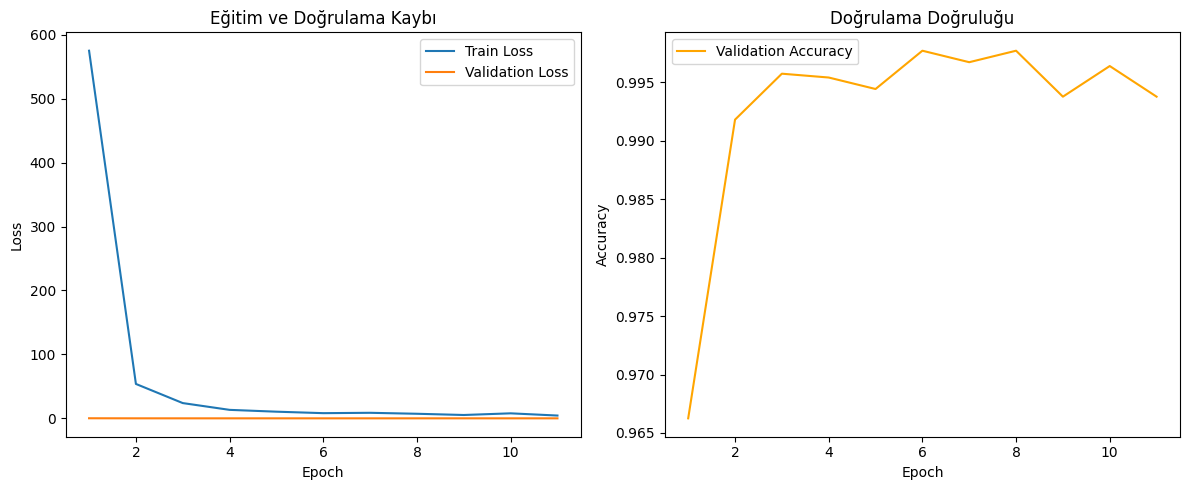

In [19]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kaybı")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Doğrulama Doğruluğu")
plt.legend()

plt.tight_layout()
plt.show()

## Değerlendirme

In [20]:
model.load_state_dict(torch.load("swin_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(pixel_values=images).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Test Set Classification Metrics ---")
print(f"Accuracy : %{accuracy * 100:.2f}")
print(f"Precision: %{precision * 100:.2f}")
print(f"Recall   : %{recall * 100:.2f}")
print(f"F1-Score : %{f1 * 100:.2f}")

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


--- Test Set Classification Metrics ---
Accuracy : %99.35
Precision: %99.37
Recall   : %99.37
F1-Score : %99.35

Detailed Classification Report:
                precision    recall  f1-score   support

      antelope       1.00      1.00      1.00        46
        badger       1.00      0.96      0.98        49
           bat       0.90      1.00      0.95        37
          bear       0.95      1.00      0.97        36
           bee       1.00      1.00      1.00        48
        beetle       1.00      1.00      1.00        34
         bison       1.00      1.00      1.00        48
          boar       1.00      1.00      1.00        42
     butterfly       1.00      1.00      1.00        43
           cat       1.00      1.00      1.00        45
   caterpillar       1.00      1.00      1.00        29
    chimpanzee       1.00      1.00      1.00        45
     cockroach       0.98      1.00      0.99        55
           cow       1.00      1.00      1.00        48
        coyot

In [21]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Doğruluk (Accuracy): %{accuracy * 100:.2f}")

Doğruluk (Accuracy): %99.35
